In [1]:
import tensorflow as tf

print(tf.__version__)
print(tf.keras.__version__)

2023-01-22 12:05:44.462220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 12:05:44.705495: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.11.0
2.11.0


In [2]:
import os
if os.path.exists('config/localconfig.py'):
    from config import localconfig as config
else:
    from config import config

In [3]:
target_paths = os.listdir(config.BB_OBJECTS)

import random
random.shuffle(target_paths)

images, targets = [], []

In [4]:
size = 1000
import json

for i in range(size):
    with open(os.path.join(config.BB_OBJECTS, target_paths[i])) as f:
        cones = json.load(f)

    image = tf.keras.utils.load_img(os.path.join(config.BB_IMAGES, target_paths[i][:-5]))
    for cone in cones:
        I_cone = tf.image.crop_to_bounding_box(image,
                                               cone['top_left']['y'],
                                               cone['top_left']['x'],
                                               cone['bottom_right']['y'] - cone['top_left']['y'],
                                               cone['bottom_right']['x'] - cone['top_left']['x'])
        images.append(tf.keras.utils.img_to_array(I_cone))
        targets.append(cone['class'])

2023-01-22 12:05:47.319361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
for i in range(len(images)):
    image = tf.keras.utils.array_to_img(images[i])
    image = image.resize((224, 224))
    images[i] = tf.keras.utils.img_to_array(image)

In [6]:
import numpy as np

(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4384, 224, 224, 3) - y_train shape: (4384,)
x_test shape: (1096, 224, 224, 3) - y_test shape: (1096,)


(-0.5, 223.5, 223.5, -0.5)

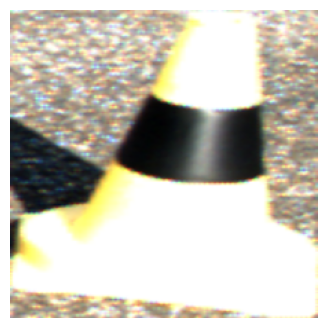

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='relu'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Accuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
history = model.fit(x_train,
                    y_train,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_split=0.1)